In [1]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.vor import *

import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

from collections import defaultdict, Counter
from copy import copy

from scipy.spatial import Voronoi
from scipy.ndimage import binary_fill_holes, gaussian_filter, binary_erosion, binary_dilation, uniform_filter

from skimage import filters
from shapely.ops import unary_union

In [5]:
TMG = TissueMultiGraph('../Analysis/Notebooks/TMG_dev5.pkl')
XY = TMG.Layers[0].XY 
d,bb1=bounding_box(XY, fill_holes=True)

In [8]:
d

11978.835502668864

In [3]:

# init vars for coord and hist
XY = TMG.Layers[0].XY 
n_xbins = 50
n_ybins = 50
padding = 10
fill_holes = False

xmax = XY.max(0)[0]
xmin = XY.min(0)[0]
ymax = XY.max(0)[1]
ymin = XY.min(0)[1]

xbins = np.arange(xmin, xmax, n_xbins)
ybins = np.arange(ymin, ymax, n_ybins)


In [4]:
# 2D histogram
hist = np.histogram2d(XY[:, 0], XY[:, 1], bins=(xbins, ybins))

# moved to uniform filter to detect holes
# Otsu's method for thresholding bw 
mask = np.array(hist[0] > 0) * 1
otsu_threshold = filters.threshold_otsu(1 - uniform_filter(mask.astype(float), size=8))
grid = 1 - uniform_filter(mask.astype(float), size=8) < otsu_threshold

if fill_holes:
    grid = binary_fill_holes(grid)

# pad the grid 
grid_pad = np.zeros(grid.shape + np.array((padding * 2, padding * 2)))
grid_pad[padding: (grid_pad.shape[0] - padding), padding : (grid_pad.shape[1] - padding)] = grid
grid = grid_pad

# detect boundary points 
border_grid = copy(grid)
for i in range(len(grid) - 1):
    for j in range(len(grid[i]) - 1):
        if grid[i, j] == 0 and sum([sum([grid[k + i, l + j] for k in range(-1, 2)]) for l in range(-1, 2)]):
            border_grid[i, j] = 2

In [5]:
def find_neigh(pos, xy_coords, redun, r=1):
    """
    Find neighbors within r radius excluding some set

    Input
    -----
    pos : position 
    xy_coords : XY coordinates
    redun : redundant set for exclusion 
    r : radius 

    Output
    ------
    list : neighbors in radius 
    """
    cand = np.array([[(pos[0] + i, pos[1] + j) for i in range(0 - r, 1 + r)] for j in range(0 - r, 1 + r)])
    cand=[x for y in cand for x in y]
    return [x for x in cand if 2 in np.sum(xy_coords == x, 1) if tuple(x) not in redun]

In [6]:
# we need to sort all of the border points into cycles
# if fill_holes == True, then this is easy, there is just one cycle
# if otherwise, then we have to iteratively find cycles from the remaining cells
x, y = np.where(border_grid == 2)
xy_coords = np.array(list(zip(x, y)))
cycles=[]
path_steps={}

# global stopping condition is when we have covered distance from start(s) to every cell
while len(path_steps)!=len(xy_coords):
    # arbitrary start that ideally avoids inner cycles on first iteration 
    start=xy_coords[np.argmin(xy_coords)]
    path_steps[tuple(start)]=[np.argmin(xy_coords)]
    pos = [start]
    idx = 0
    # once we have run out of candidates, we have covered all cells within a cycle 
    while len(pos) > idx:
        cand = find_neigh(pos[idx], xy_coords, path_steps)
        for c in cand:
            if tuple(c) not in path_steps:
                idx_count = Counter(np.where(xy_coords == c)[0])
                path_steps[tuple(c)] = path_steps[tuple(pos[idx])] + [x for x in idx_count if idx_count[x] == 2]
                pos += [c]
        idx += 1

    # find set of cells connecting two neighbors to start
    path_dict = {}
    keys = [tuple(list(x)) for x in pos]
    key_dict = {x: idx for idx, x in enumerate(keys)}

    for x in pos:
        x = tuple(list(x))
        for y in find_neigh(x, xy_coords, {}):
            y = tuple(y)
            if not np.product(x == y):
                idx = key_dict[x]
                idy = key_dict[y]
                # if two paths are distinct, then the set of their combined elements will be relatively large 
                path_dict[(idx, idy)] = len(set(path_steps[tuple(x)] + path_steps[tuple(y)]))

    # find longest path 
    max_x, max_y = max(path_dict, key = path_dict.get)
    order = path_steps[keys[max_x]] + path_steps[keys[max_y]][::-1][:-1]

    # add to cycle set and update coords to remove cells from cycle
    cycles += [(order, np.array([xy_coords[i] for i in order]))]
    xy_coords = [xy for xy in xy_coords if tuple(xy) not in path_steps]

    if len(xy_coords) == 1:
        cycles += [([0], xy_coords)]
        break
    if len(xy_coords) == 0:
        break

In [7]:
# construct mapping of grid with padding back to coordinates
# 2D hist contains three dimensions: 2D counts and x/y coords
hist2coord = {}

# inner points, average between bins 
for i in range(hist[0].shape[0]):
    for j in range(hist[0].shape[1]):
        hist2coord[(i + padding, j + padding)] = ((hist[1][i] + hist[1][i + 1]) / 2, (hist[2][j] + hist[2][j + 1]) / 2)

# [0, padding] x difference, inner y 
for i in range(padding)[::-1]:
    for j in range(hist[0].shape[1]):
            a = hist2coord[(i + 1, j + padding)]
            b = hist2coord[(i + 2, j + padding)]
            hist2coord[(i, j + padding)] = np.array(a) + np.array(a) - np.array(b)

# [xrange + padding, xrange + padding * 2] x difference, inner y 
for i in range(hist[0].shape[0], hist[0].shape[0] + padding * 2):
    for j in range(hist[0].shape[1]):
            a=hist2coord[(i - 1, j + padding)]
            b=hist2coord[(i - 2, j + padding)]
            hist2coord[(i, j + padding)] = np.array(a) + np.array(a) - np.array(b)

# all of x, [0, padding] y difference
for i in range(hist[0].shape[0] + padding * 2):
    for j in range(padding)[::-1]:
        a=hist2coord[(i, j + 1)]
        b=hist2coord[(i, j + 2)]
        hist2coord[(i, j)] = np.array(a) + np.array(a) - np.array(b)

# all of x, [yrange + padding, yrange + padding * 2] y difference
for i in range(hist[0].shape[0] + padding * 2):
    for j in range(hist[0].shape[1], hist[0].shape[1] + padding * 2):
        a = hist2coord[(i, j - 1)]
        b = hist2coord[(i, j - 2)]
        hist2coord[(i, j)] = np.array(a) + np.array(a) - np.array(b)

In [8]:
bb = list(map(lambda xy_coords: np.array([hist2coord[tuple(x)] for x in xy_coords]), [x[1] for x in cycles]))
bb = [x for x in bb if len(x) >= 10]

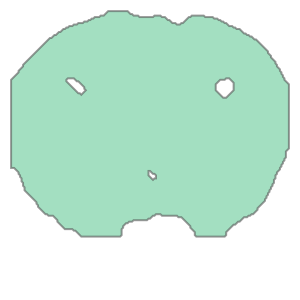

In [13]:
Polygon(bb[0])-Polygon(bb[1])-Polygon(bb[2])-Polygon(bb[3])

In [16]:
bb[0].ptp(axis=1)

array([ 769.25287817,  719.25287817,  669.25287817,  569.25287817,
        469.25287817,  369.25287817,  319.25287817,  219.25287817,
        169.25287817,   69.25287817,   19.25287817,   30.74712183,
        130.74712183,  180.74712183,  230.74712183,  330.74712183,
        380.74712183,  430.74712183,  530.74712183,  630.74712183,
        730.74712183,  830.74712183,  930.74712183, 1030.74712183,
       1130.74712183, 1230.74712183, 1280.74712183, 1380.74712183,
       1430.74712183, 1530.74712183, 1630.74712183, 1730.74712183,
       1830.74712183, 1930.74712183, 1980.74712183, 2080.74712183,
       2130.74712183, 2180.74712183, 2230.74712183, 2330.74712183,
       2430.74712183, 2530.74712183, 2580.74712183, 2680.74712183,
       2780.74712183, 2880.74712183, 2980.74712183, 3080.74712183,
       3130.74712183, 3180.74712183, 3230.74712183, 3280.74712183,
       3330.74712183, 3430.74712183, 3480.74712183, 3580.74712183,
       3680.74712183, 3780.74712183, 3880.74712183, 3930.74712

In [ ]:
def bounding_box(XY, n_xbins=50, n_ybins=50, padding=10, size_thr=10, fill_holes=False):
    """
    """

    xmax = XY.max(0)[0]
    xmin = XY.min(0)[0]
    ymax = XY.max(0)[1]
    ymin = XY.min(0)[1]

    xbins = np.arange(xmin, xmax, n_xbins)
    ybins = np.arange(ymin, ymax, n_ybins)

    # 2D histogram
    hist = np.histogram2d(XY[:, 0], XY[:, 1], bins=(xbins, ybins))

    # moved to uniform filter to detect holes
    # Otsu's method for thresholding bw 
    mask = np.array(hist[0] > 0) * 1
    otsu_threshold = filters.threshold_otsu(1 - uniform_filter(mask.astype(float), size=8))
    grid = 1 - uniform_filter(mask.astype(float), size=8) < otsu_threshold

    if fill_holes:
        grid = binary_fill_holes(grid)

    # pad the grid 
    grid_pad = np.zeros(grid.shape + np.array((padding * 2, padding * 2)))
    grid_pad[padding: (grid_pad.shape[0] - padding), padding : (grid_pad.shape[1] - padding)] = grid
    grid = grid_pad

    # detect boundary points 
    border_grid = copy(grid)
    for i in range(len(grid) - 1):
        for j in range(len(grid[i]) - 1):
            if grid[i, j] == 0 and sum([sum([grid[k + i, l + j] for k in range(-1, 2)]) for l in range(-1, 2)]):
                border_grid[i, j] = 2
    
    # we need to sort all of the border points into cycles
    # if fill_holes == True, then this is easy, there is just one cycle
    # if otherwise, then we have to iteratively find cycles from the remaining cells
    x, y = np.where(border_grid == 2)
    xy_coords = np.array(list(zip(x, y)))
    cycles=[]
    path_steps={}

    # global stopping condition is when we have covered distance from start(s) to every cell
    while len(path_steps)!=len(xy_coords):
        order = find_order(xy_coords)
        # add to cycle set and update coords to remove cells from cycle
        cycles += [(order, np.array([xy_coords[i] for i in order]))]
        xy_coords = [xy for xy in xy_coords if tuple(xy) not in path_steps]

        if len(xy_coords) == 1:
            cycles += [([0], xy_coords)]
            break
        if len(xy_coords) == 0:
            break

    hist2coord = find_hist_mapping(hist)
    bb = list(map(lambda xy_coords: np.array([hist2coord[tuple(x)] for x in xy_coords]), [x[1] for x in cycles]))
    bb = [x for x in bb if len(x) >= size_thr]
    diameter = np.linalg.norm(bb[0].ptp(axis=0))

    return diameter, Polygon(bb[0])-unary_union([Polygon(bb[i]) for i in range(1, len(bb))])

In [ ]:
def find_order(xy_coords):
    """
    """
    # arbitrary start that ideally avoids inner cycles on first iteration 
    start=xy_coords[np.argmin(xy_coords)]
    path_steps[tuple(start)]=[np.argmin(xy_coords)]
    pos = [start]
    idx = 0
    # once we have run out of candidates, we have covered all cells within a cycle 
    while len(pos) > idx:
        cand = find_neigh(pos[idx], xy_coords, path_steps)
        for c in cand:
            if tuple(c) not in path_steps:
                idx_count = Counter(np.where(xy_coords == c)[0])
                path_steps[tuple(c)] = path_steps[tuple(pos[idx])] + [x for x in idx_count if idx_count[x] == 2]
                pos += [c]
        idx += 1

    # find set of cells connecting two neighbors to start
    path_dict = {}
    keys = [tuple(list(x)) for x in pos]
    key_dict = {x: idx for idx, x in enumerate(keys)}

    for x in pos:
        x = tuple(list(x))
        for y in find_neigh(x, xy_coords, {}):
            y = tuple(y)
            if not np.product(x == y):
                idx = key_dict[x]
                idy = key_dict[y]
                # if two paths are distinct, then the set of their combined elements will be relatively large 
                path_dict[(idx, idy)] = len(set(path_steps[tuple(x)] + path_steps[tuple(y)]))

    # find longest path 
    max_x, max_y = max(path_dict, key = path_dict.get)
    return path_steps[keys[max_x]] + path_steps[keys[max_y]][::-1][:-1]

In [ ]:
def find_hist_mapping(hist):
    """
    """
    # construct mapping of grid with padding back to coordinates
    # 2D hist contains three dimensions: 2D counts and x/y coords
    hist2coord = {}

    # inner points, average between bins 
    for i in range(hist[0].shape[0]):
        for j in range(hist[0].shape[1]):
            hist2coord[(i + padding, j + padding)] = ((hist[1][i] + hist[1][i + 1]) / 2, (hist[2][j] + hist[2][j + 1]) / 2)

    # [0, padding] x difference, inner y 
    for i in range(padding)[::-1]:
        for j in range(hist[0].shape[1]):
                a = hist2coord[(i + 1, j + padding)]
                b = hist2coord[(i + 2, j + padding)]
                hist2coord[(i, j + padding)] = np.array(a) + np.array(a) - np.array(b)

    # [xrange + padding, xrange + padding * 2] x difference, inner y 
    for i in range(hist[0].shape[0], hist[0].shape[0] + padding * 2):
        for j in range(hist[0].shape[1]):
                a=hist2coord[(i - 1, j + padding)]
                b=hist2coord[(i - 2, j + padding)]
                hist2coord[(i, j + padding)] = np.array(a) + np.array(a) - np.array(b)

    # all of x, [0, padding] y difference
    for i in range(hist[0].shape[0] + padding * 2):
        for j in range(padding)[::-1]:
            a=hist2coord[(i, j + 1)]
            b=hist2coord[(i, j + 2)]
            hist2coord[(i, j)] = np.array(a) + np.array(a) - np.array(b)

    # all of x, [yrange + padding, yrange + padding * 2] y difference
    for i in range(hist[0].shape[0] + padding * 2):
        for j in range(hist[0].shape[1], hist[0].shape[1] + padding * 2):
            a = hist2coord[(i, j - 1)]
            b = hist2coord[(i, j - 2)]
            hist2coord[(i, j)] = np.array(a) + np.array(a) - np.array(b)
    return hist2coord